# Librerías

In [10]:
import math, re, os, zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

Tensorflow version 2.19.0


# Extraer directorios de .zip

In [11]:
# Ruta del archivo ZIP
zip_path = 'C:/Users/Sebastian/Documents/GitHub/clasificacion_flores/data/raw/flower-classification-with-tpus.zip'

# Extraer el contenido
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('C:/Users/Sebastian/Documents/GitHub/clasificacion_flores/data/raw')

# Variables y ubicaciones

In [12]:
# ==== Configuración de variables ====

classes = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

# tfrecords jpeg 224x224 path
ds_path = 'C:/Users/Sebastian/Documents/GitHub/clasificacion_flores/data/raw/tfrecords-jpeg-224x224'

train_files = tf.io.gfile.glob(f"{ds_path}/train/*.tfrec")
val_files = tf.io.gfile.glob(f"{ds_path}/val/*.tfrec")
test_files = tf.io.gfile.glob(f"{ds_path}/test/*.tfrec") 

# Función para visualización

In [39]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(classes)))
    ax.set_yticklabels(classes, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    plt.savefig('cm.jpg')

# Funciones Preprocesamiento

In [14]:
# ==== Funciones para manejo de datos obtenidas del Kaggle ====

AUTO = tf.data.experimental.AUTOTUNE
image_size = [224, 224]
batch_size = 32

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.efficientnet.preprocess_input(image)  # Normaliza para EfficientNet
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.6, 1.6)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

def get_training_dataset():
    dataset = load_dataset(train_files, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(val_files, labeled=True, ordered=ordered)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(test_files, labeled=False, ordered=ordered)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

num_training_images = count_data_items(train_files)
num_val_images = count_data_items(val_files)
num_test_images = count_data_items(test_files)
steps_per_epoch = num_training_images // batch_size
val_steps = -(-num_val_images // batch_size)
test_steps = -(-num_test_images // batch_size)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(num_training_images, num_val_images, num_test_images))


train = get_training_dataset()
val = get_validation_dataset()
test = get_test_dataset()

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


# Modelo

In [15]:
# ==== Transferencia de aprendizaje ====
# Modelo utilizado: EfficientNetV2 (B0)
# Nos ofrece una arquitectura moderna optimizada para datasets medianos, y B0 (7.1M params) es rápido y suficiente.

# Cargar modelo base (pre-entrenado)
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'  # GlobalAveragePooling2D
    )

# Congelar capas, luego descongelar para fine-tuning
base_model.trainable = False

# Añadir capas personalizadas
model = tf.keras.Sequential([
    base_model,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3), 
    layers.Dense(len(classes), activation='softmax')
    ])

# Compilar
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
    )

# Entrenar
history = model.fit(
    train,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_data=val,
    validation_steps=val_steps,
)

Epoch 1/15
398/398 ━━━━━━━━━━━━━━━━━━━━ 315s 745ms/step - loss: 2.7787 - sparse_categorical_accuracy: 0.3851 - val_loss: 0.9621 - val_sparse_categorical_accuracy: 0.7570
Epoch 2/15
398/398 ━━━━━━━━━━━━━━━━━━━━ 357s 897ms/step - loss: 1.0545 - sparse_categorical_accuracy: 0.7248 - val_loss: 0.7246 - val_sparse_categorical_accuracy: 0.8050
Epoch 3/15
398/398 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - loss: 0.7984 - sparse_categorical_accuracy: 0.7827 - val_loss: 0.6234 - val_sparse_categorical_accuracy: 0.8287
Epoch 4/15
398/398 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - loss: 0.6674 - sparse_categorical_accuracy: 0.8108 - val_loss: 0.5794 - val_sparse_categorical_accuracy: 0.8416
Epoch 5/15
398/398 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - loss: 0.5737 - sparse_categorical_accuracy: 0.8324 - val_loss: 0.5493 - val_sparse_categorical_accuracy: 0.8505
Epoch 6/15
398/398 ━━━━━━━━━━━━━━━━━━━━ 397s 998ms/step - loss: 0.5517 - sparse_categorical_accuracy: 0.8459 - val_loss: 0.5444 - val_sparse_categorical_accura

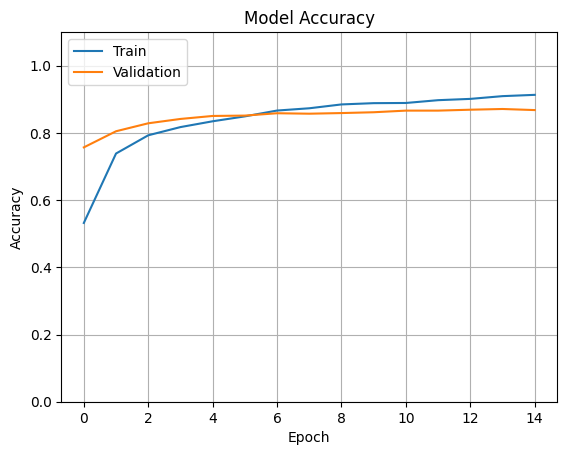

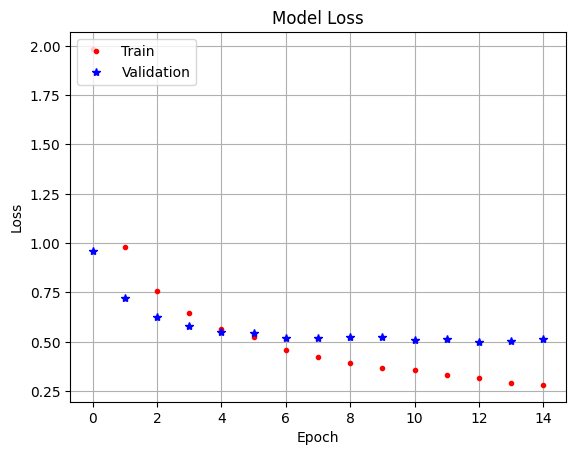

In [16]:
# Visualización antes de fine-tuning
# Grafica de accuracy
def plot_hist(hist):
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.ylim((0,1.1))
    plt.grid()
    plt.show()
    plt.savefig('accuracy.jpg')
    plt.close()

plot_hist(history)

# Grafica de loss
def plot_hist_loss(hist):
    plt.plot(hist.history["loss"],'.r')
    plt.plot(hist.history["val_loss"],'*b')
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    #plt.ylim((0,1))
    plt.grid()
    plt.show()
    plt.savefig('loss.jpg')
    plt.close()

plot_hist_loss(history)

In [17]:
# Fine-tuning
# Descongelar capas superiores
base_model.trainable = True

for layer in base_model.layers[:-10]:  # Descongelar solo las últimas 10 capas
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Bajar el learning rate a 1e-5
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy']
              )

history_finetune = model.fit(
    train,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_data=val,
    validation_steps=val_steps
)

Epoch 1/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 324s 791ms/step - loss: 0.5707 - sparse_categorical_accuracy: 0.8358 - val_loss: 0.6167 - val_sparse_categorical_accuracy: 0.8475
Epoch 2/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 320s 804ms/step - loss: 0.4672 - sparse_categorical_accuracy: 0.8679 - val_loss: 0.5773 - val_sparse_categorical_accuracy: 0.8559
Epoch 3/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 325s 817ms/step - loss: 0.4192 - sparse_categorical_accuracy: 0.8796 - val_loss: 0.5456 - val_sparse_categorical_accuracy: 0.8599
Epoch 4/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 323s 813ms/step - loss: 0.3932 - sparse_categorical_accuracy: 0.8848 - val_loss: 0.5349 - val_sparse_categorical_accuracy: 0.8623
Epoch 5/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 323s 811ms/step - loss: 0.3446 - sparse_categorical_accuracy: 0.8958 - val_loss: 0.5195 - val_sparse_categorical_accuracy: 0.8669


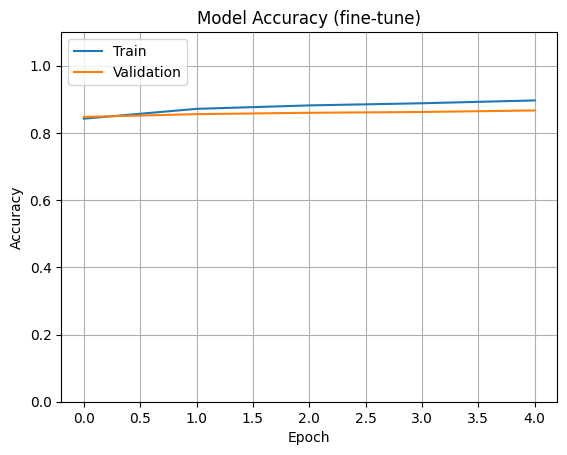

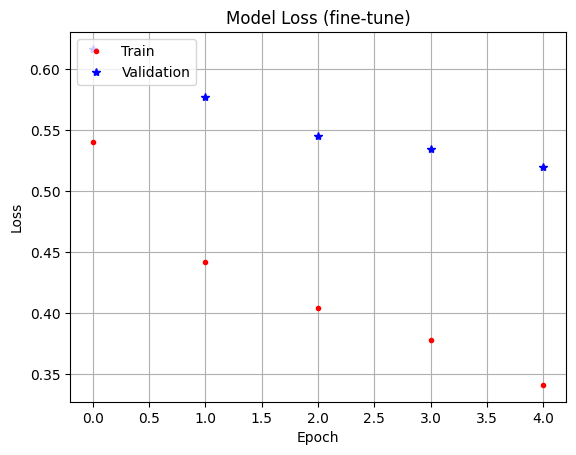

In [18]:
# Visualización despues de fine-tuning
# Grafica de accuracy
def plot_hist(hist):
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("Model Accuracy (fine-tune)")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.ylim((0,1.1))
    plt.grid()
    plt.show()
    plt.savefig('accuracy_fine_tuning.jpg')
    plt.close()

plot_hist(history_finetune)

# Grafica de loss
def plot_hist_loss(hist):
    plt.plot(hist.history["loss"],'.r')
    plt.plot(hist.history["val_loss"],'*b')
    plt.title("Model Loss (fine-tune)")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    #plt.ylim((0,1))
    plt.grid()
    plt.show()
    plt.savefig('loss_fine_tuning.jpg')
    plt.close()

plot_hist_loss(history_finetune)

In [37]:
# Obtener test sin etiquetas
test_ds = get_test_dataset(ordered=True)

# Separar imágenes e ids
test_images = test_ds.map(lambda image, idnum: image)
test_ids = test_ds.map(lambda image, idnum: idnum)

# Obtener predicciones
test_pred_probs = model.predict(test_images, steps=test_steps)
test_preds = np.argmax(test_pred_probs, axis=-1)

# Obtener todos los ids del conjunto de prueba
ids = []
for batch in test_ids:
    for id in batch.numpy():
        ids.append(id.decode("utf-8"))

# Crear DataFrame con las predicciones
pred_df = pd.DataFrame({
    'id': ids,
    'label': test_preds
})

# Cargar el archivo submission.csv
output_submission = pd.read_csv('C:/Users/Sebastian/Documents/GitHub/clasificacion_flores/data/raw/output_submission.csv')

# Merge de DataFrames con etiquetas verdaderas y predicciones
merged = pd.merge(output_submission, pred_df, on='id', how='inner')

# Comparar las predicciones con las etiquetas verdaderas
y_true = merged['label_x']  # Etiquetas verdaderas
y_pred = merged['label_y']  # Predicciones

# Generar matriz de confusión y reporte de clasificación
print(confusion_matrix(y_true, y_pred, labels=range(len(classes))))
print(classification_report(y_true, y_pred))


231/231 ━━━━━━━━━━━━━━━━━━━━ 153s 660ms/step
[[123   0   0 ...   0   0   4]
 [  0  15   0 ...   0   0   0]
 [  0   0   0 ...   0   0   1]
 ...
 [  0   0   0 ...  15   0   0]
 [  0   0   0 ...   0 155   1]
 [  5   0   1 ...   0   0 410]]
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       153
           1       0.83      0.94      0.88        16
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         6
           4       0.85      0.72      0.78       518
           5       0.87      0.82      0.84        55
           6       0.83      0.83      0.83        12
           7       0.90      0.98      0.94        58
           8       0.85      0.82      0.84        50
           9       0.91      0.93      0.92        44
          10       0.75      0.69      0.72        81
          11       0.96      0.96      0.96        23
          12       0.92      0.84      0.88        58
      

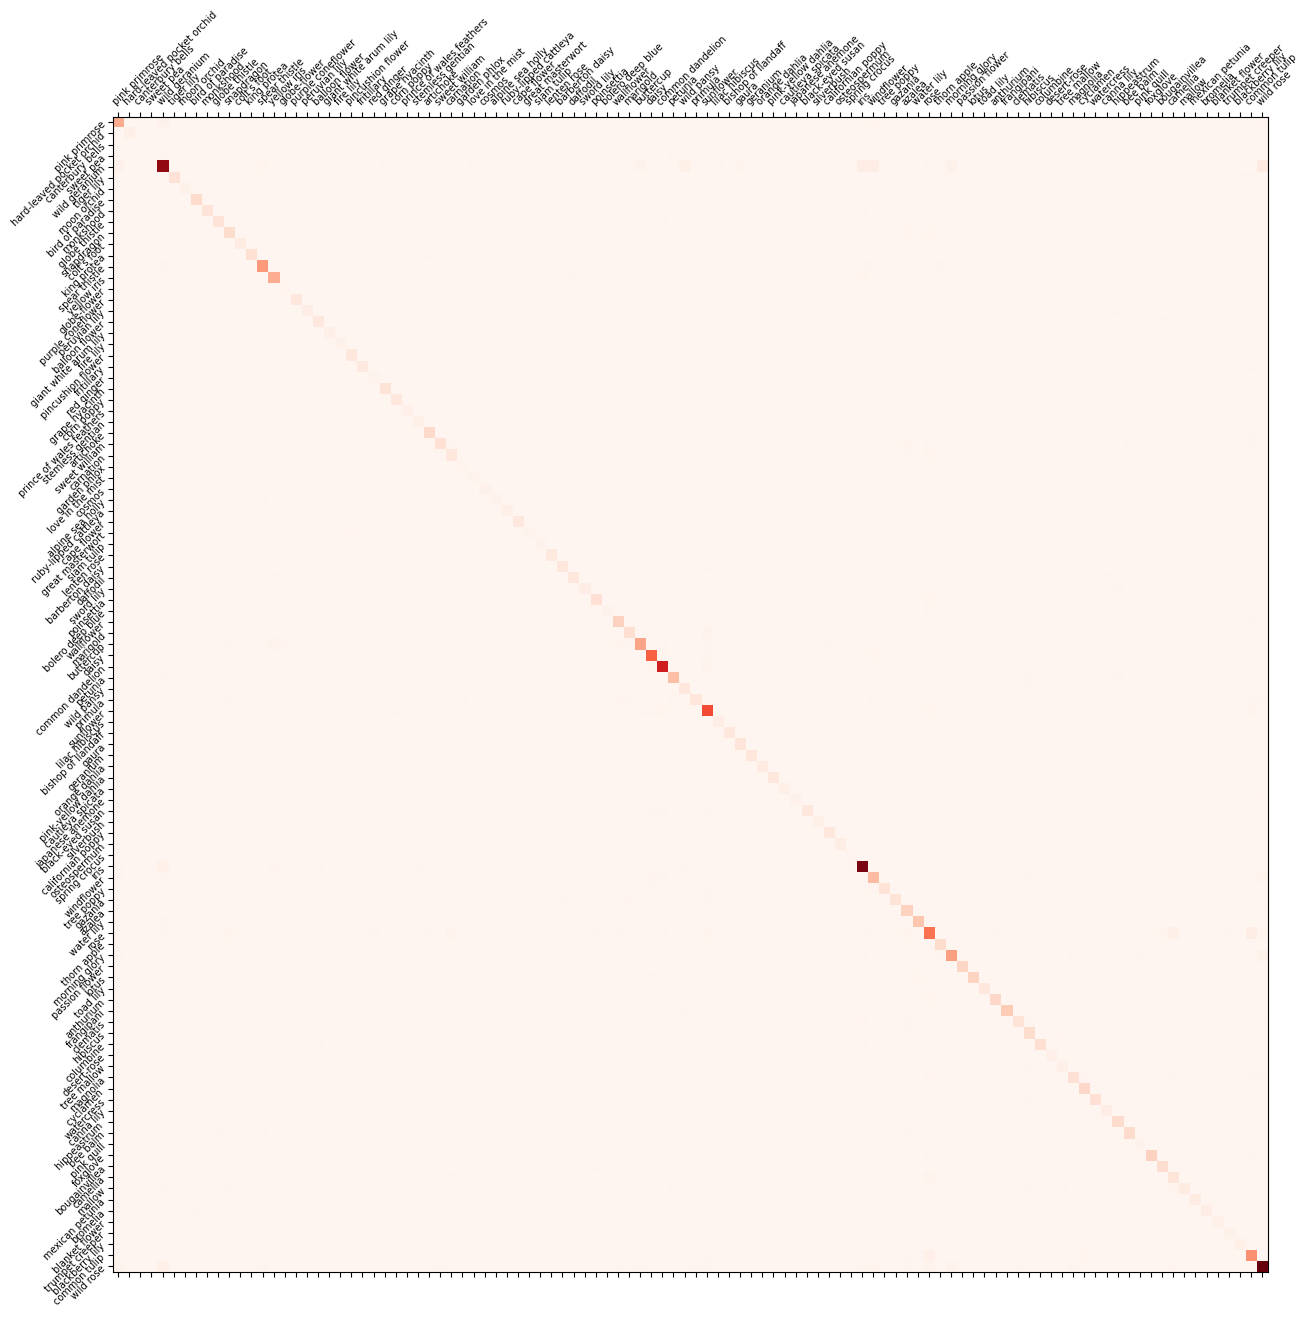

<Figure size 640x480 with 0 Axes>

In [40]:
cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))

display_confusion_matrix(cm, score=None, precision=None, recall=None)

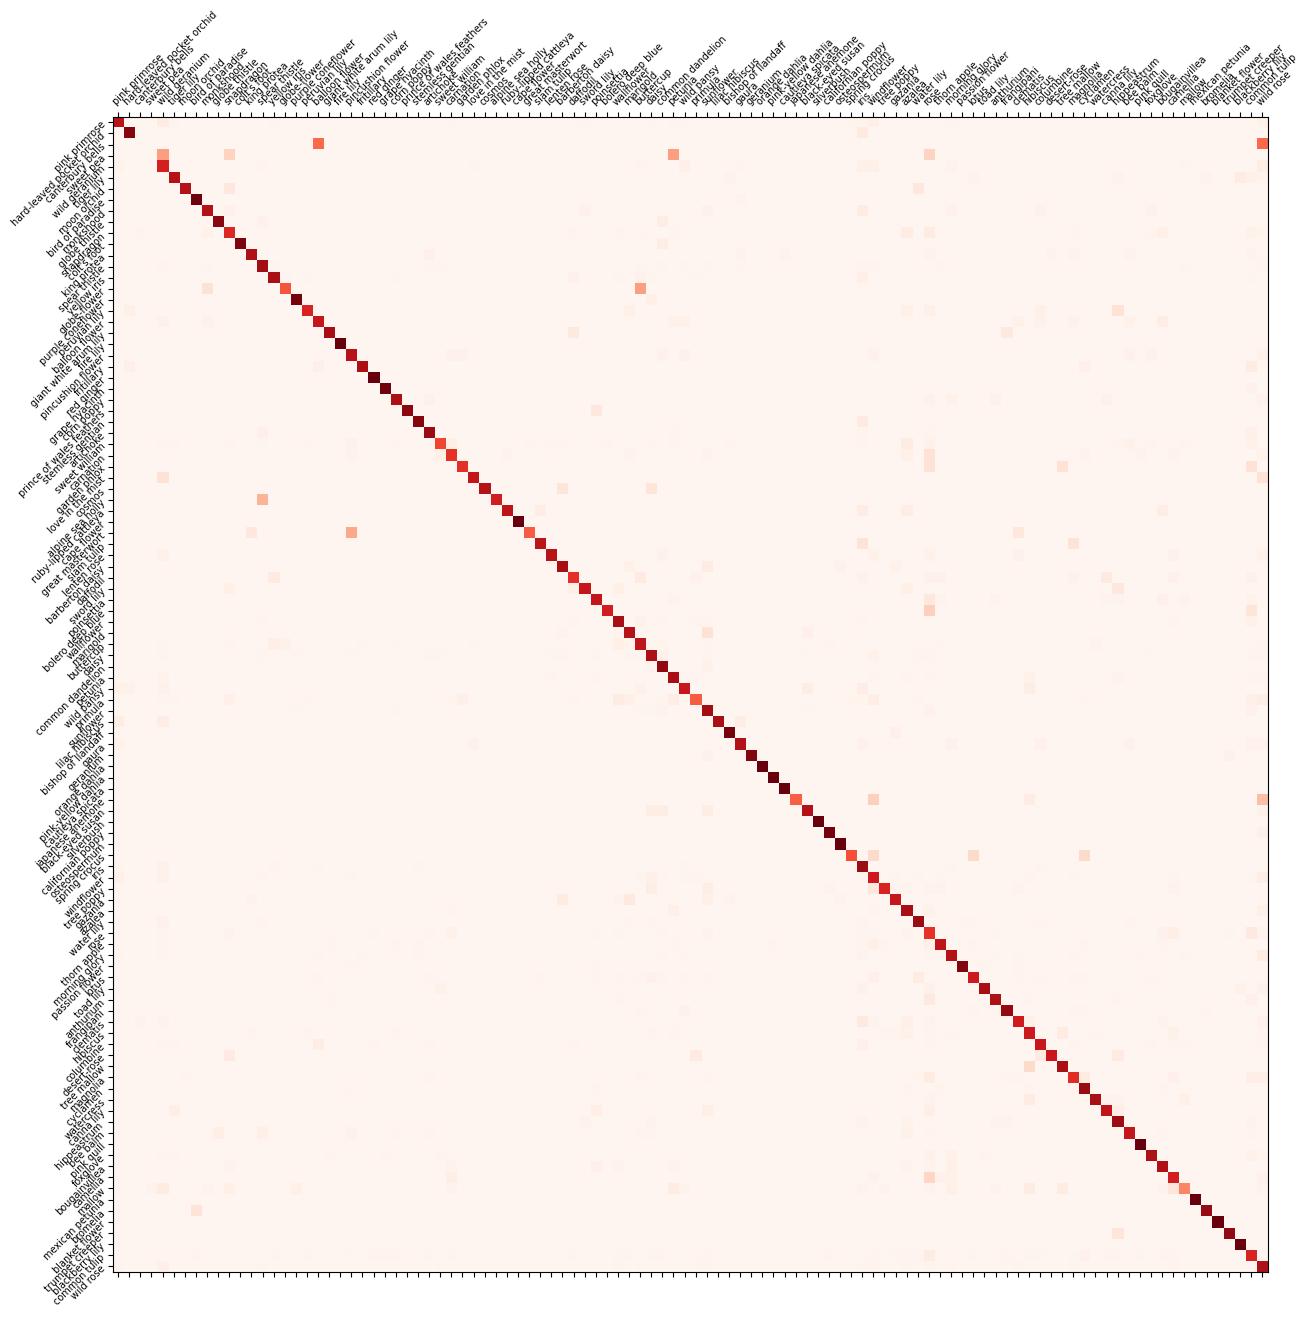

<Figure size 640x480 with 0 Axes>

In [41]:
cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
cm_norm = (cm.T / cm.sum(axis=1)).T

display_confusion_matrix(cm_norm, score=None, precision=None, recall=None)